OrderedDict([(1000.0, [6.2515600000000004, 6.11803, 6.09389, 6.08877, 6.145560000000001]), (5000.0, [6.1448, 6.13796, 6.08023, 6.15614, 6.21023]), (10000.0, [6.492159999999999, 6.16002, 6.084099999999999, 6.0751, 6.172059999999999]), (15000.0, [6.08157, 6.05404, 6.08529, 9.09072, 6.06961]), (20000.0, [8.11831, 6.096089999999999, 6.0569, 6.062259999999999, 6.06759])])
OrderedDict([(1000.0, [7.4873899999999995, 7.51831, 7.54311, 7.6212800000000005, 7.5171]), (5000.0, [7.50033, 7.42997, 7.514119999999999, 7.452800000000001, 7.4996599999999995]), (10000.0, [7.5465800000000005, 7.47161, 7.524540000000001, 7.4909300000000005, 7.4381200000000005]), (15000.0, [7.6555, 7.47935, 7.42069, 7.499670000000001, 7.43905]), (20000.0, [7.470059999999999, 7.43001, 7.45421, 7.494280000000001, 7.58403])])


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure i

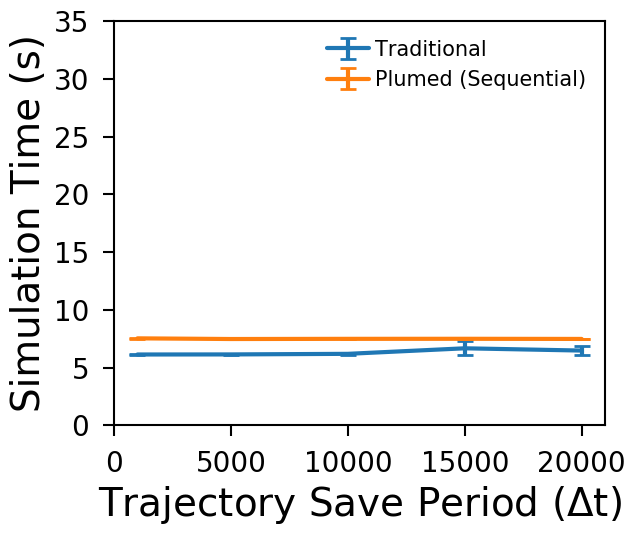

In [4]:
import numpy as np
import os
from glob import iglob
from collections import defaultdict
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import collections

def timestamp_to_seconds(t):
    return sum(float(n) * m for n, m in zip(reversed(t), (1, 60, 3600)))


# This will return absolute paths
paths = {'sequential_using_mdtraj':'Traditional','sequential_in_transit_plumed_global_module':'Plumed (Sequential)'}
sim_time_labels = ['Pair','Neigh','Comm','Other'] # Modify and Output is left out
for path,legend in paths.items():
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/T_*/log.prod'.format(path), recursive=True)]
    for log_file in log_files:
        total_time=None
        directory_name = log_file.split('/')[-2]
        dump_interval = float(directory_name.split('_')[5])
        sim_time = 0
        if dump_interval>500:
            with open(log_file) as fp:
                line = fp.readline()
                #print(line)
                while line:
                    values = line.split('|')
                    if len(values)== 6 and any(label in values[0] for label in sim_time_labels):
                        values = line.split('|')
                        sim_time += float(values[2])

                    line = fp.readline()
            if sim_time>0:
                #print(log_file)
                sim_time_dict[dump_interval].append(sim_time)
            else:
                #print('Could not find sim time in ',log_file)
                continue
    #print(sim_time_dict)
    od = collections.OrderedDict(sorted(sim_time_dict.items()))
    print(od)
    sim_time_dict=od
    mean_tts = [np.mean(sim_time_vals) for dump_interval, sim_time_vals in sim_time_dict.items()]
    std_tts = [stats.sem(sim_time_vals) for dump_interval, sim_time_vals in sim_time_dict.items()]
    dump_intervals = sim_time_dict.keys()
    plt.errorbar(dump_intervals,
                 mean_tts,
                 std_tts, 
                 #fmt='o', 
                 #ecolor='g',
                 capsize=6, 
                 #elinewidth=3,
                 capthick=2,
                label=legend)
plt.xlabel("Trajectory Save Period ($\Delta$t)")
plt.ylabel("Simulation Time (s)")
plt.legend(fontsize=15)
plt.ylim(0,35)
plt.xlim(0,21000)
plt.savefig('figure_sim_time.png', transparent=True)
plt.show()